In [1]:
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
import rasterio.plot

import sklearn
from sklearn import cluster, mixture

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from func_utils import reject_outliers, nearest_date, clean_values, time_col_filter

Série temporelle Sentinel 2 constituée de 83 images
Série temporelle Pléiades constituée de 12 images
Parcelles OLD : 14587
Parcelles autres : 140044
Montpellier :
    Parcelles OLD : 2547
    Parcelles autres : 36212


No handles with labels found to put in legend.


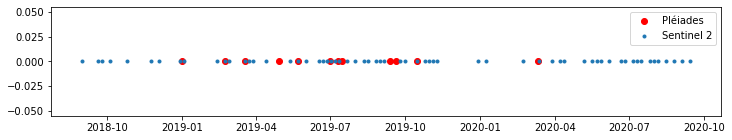

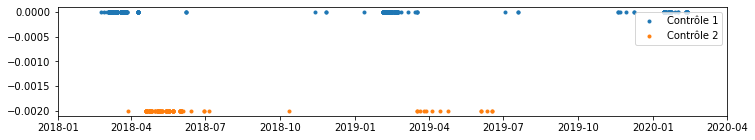

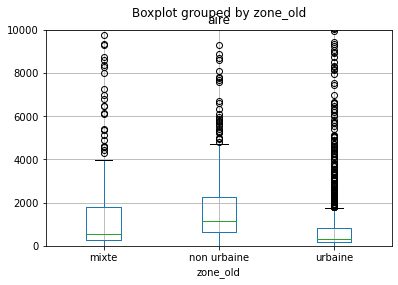

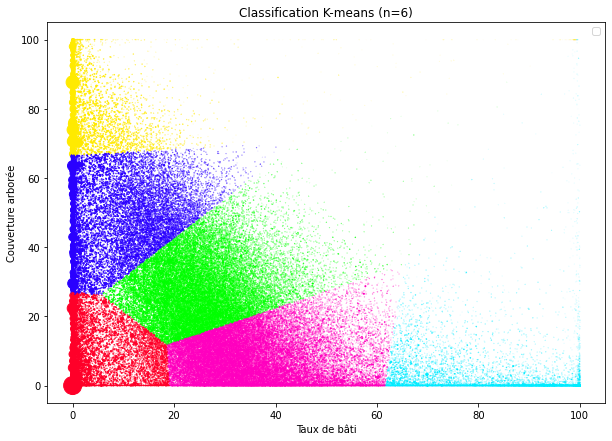

In [2]:
from post_process import *

In [76]:
def control_info(ident, control):
    info = control[control.codeident == ident][['codeident', 'c1_date', 'c1_conformite', 'c2_date', 'c2_conformite']]
    return info if len(info) > 0 else None


def extract_info(locidx, data, orig_data, control):
    values = data.loc[locidx]
    gid = orig_data.loc[locidx]['gid']
    assert gid == locidx
    ident = orig_data.loc[locidx]['codeident']
    label = f"{locidx}: {ident}"
    if control is not None:
        info = control_info(ident, control)
    else:
        info = None

    return (values, gid, ident, label, info)


def ndvi_plot(choices: np.array,
              s2_ndvi_stats: gpd.GeoDataFrame,
              s2_orig_data: gpd.GeoDataFrame,
              control: gpd.GeoDataFrame,
              reject: int = 0,
              interpolate: bool = True,
              rolling_win: int = 0,
              outfile: str = "",
              size_factor: int = 1):
        
    #np.random.shuffle(COLORS)
    _fsize = (int(len(s2_ndvi_stats.columns)/3  * size_factor),
                                    int(9 * size_factor))
    fig, ax = plt.subplots(figsize=_fsize)

    informations = []
    if isinstance(choices, int):
        choices = [choices]
    for i, ch in enumerate(choices):
        color = COLORS[i]
        values, gid, code_id, label, info = extract_info(ch, s2_ndvi_stats, s2_orig_data, control)

        values = clean_values(values, reject, interpolate, rolling_win)
        c_dtimes = s2_ndvi_stats.columns.to_pydatetime()
        
        plt.plot(c_dtimes, values, label=label, linestyle='-', marker='.', c=color)
        if info is not None:
            informations.append(info)
            y = values.mean()
            #y = 0.03
            for n, v in enumerate(info.values):
                d1 = v[1]
                if not pd.isna(d1):
                    conform1 = v[2]
                    label1 = 'conforme' if conform1 else 'non conforme'
                    symbol1 = 'D' if conform1 else 'x'
                    ax.scatter(d1, y, marker=symbol1, s=100, c=color, alpha=0.7)
                d2 = v[3]
                if not pd.isna(d2):
                    conform2 = v[4]
                    label2 = 'conforme' if conform2 else 'non conforme'
                    symbol2 = 'D' if conform2 else 'x'
                    ax.scatter(d2, y, marker=symbol2, s=100, c=color, alpha=0.7)

    ax.legend()
    ax.set_ylim(0, 1.0)

    if outfile:
        fig.savefig(outfile, bbox_inches='tight', dpi=int(150*size_factor))
    if informations:
        return pd.concat(informations)


def ndvi_diff_plot(dt, diff, parcelles, days=30, size=(15,15), vmin=-0.3,vmax=0.3, sat='Pléiades'):
    stats = time_col_filter(diff, dt, delta=-days).sum(axis=1).rename('diff')
    fig, ax = plt.subplots(figsize=size)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ax.set_title(f'Variation du NDVI {sat} dans les {days}j avant le {dt}')
    parcelles.join(stats).plot(column='diff',legend=True,ax=ax, cax=cax,cmap='RdYlGn',vmin=vmin, vmax=vmax)
    return fig


COLORS =['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [4]:
ndvi_mean[ndvi_mean.columns[45:]]

2019-07-22  2019-08-01  2019-08-11  2019-08-16  2019-08-26  \
1         0.311925    0.287359    0.259581    0.287032    0.284061   
2         0.579300    0.484578         NaN    0.467964    0.474090   
3         0.164387         NaN    0.134270    0.188125    0.212807   
4         0.288792    0.278193    0.254536    0.291494    0.313627   
5         0.404683    0.384465    0.278734    0.369195    0.375650   
...            ...         ...         ...         ...         ...   
167663    0.280317    0.244812         NaN    0.249430    0.247552   
167664    0.546975    0.538928    0.542406    0.498713    0.518278   
167665    0.610175    0.615247    0.610435    0.573857    0.597966   
167666    0.233601    0.233566         NaN    0.231429    0.226912   
167667    0.355210    0.353494    0.348983    0.345015    0.346899   

        2019-08-31  2019-09-05  2019-09-25  2019-09-30  2019-10-15  ...  \
1         0.275741    0.302406    0.274549    0.299566    0.325480  ...   
2         0.461690    0.452857         NaN    0.520281    0.535036  ...   
3         0.134986    0.261772    0.197545    0.154937    0.276693  ...   
4         0.266627    0.309334    0.359361         NaN    0.392498  ...   
5         0.375949    0.352235    0.407116    0.398267    0.418577  ...   
...            ...         ...         ...         ...         ...  ...   
167663    0.247455    0.238534    0.286373    0.268669    0.273843  ...   
167664    0.521054    0.492739    0.535059    0.555144    0.583388  ...   
167665    0.590105    0.576093    0.612579    0.628373    0.674146  ...   
167666    0.238785    0.228688    0.269516    0.266181    0.298566  ...   
167667    0.333160    0.348677    0.365025    0.363703    0.392257  ...   

        2020-07-06  2020-07-11  2020-07-16  2020-07-26  2020-07-31  \
1         0.273482    0.281214    0.282848    0.247475    0.301069   
2         0.493263    0.527861    0.546307    0.427129    0.479701   
3         0.132189    0.153531    0.171211    0.170647    0.217285   
4         0.287141         NaN    0.258124    0.266349    0.325265   
5         0.446026    0.423701    0.417810    0.422485    0.397523   
...            ...         ...         ...         ...         ...   
167663    0.305065    0.305545    0.293411    0.295065    0.303931   
167664    0.610465    0.597292    0.600300    0.590930    0.553490   
167665    0.672628    0.664016    0.663296    0.661507    0.622791   
167666    0.275420    0.257369    0.259703    0.275155    0.257017   
167667    0.443080    0.410473    0.399592    0.391503    0.391034   

        2020-08-05  2020-08-15  2020-08-25  2020-09-04  2020-09-14  
1         0.276639    0.267305    0.303996    0.280507    0.252614  
2         0.424847    0.426891    0.491315    0.421041    0.458153  
3         0.168140    0.165841    0.149456    0.187988    0.190101  
4         0.272080    0.289157    0.304350    0.326155    0.272334  
5         0.407189    0.413602    0.399432    0.426744    0.426223  
...            ...         ...         ...         ...         ...  
167663    0.294058    0.284920    0.290708    0.335352    0.376166  
167664    0.571656    0.567036    0.586118    0.601586    0.610085  
167665    0.637235    0.634529    0.652480    0.674489    0.695693  
167666    0.270106    0.261761    0.268295    0.298800    0.327562  
167667    0.387265    0.387959    0.402444    0.425444    0.457952  

[153062 rows x 38 columns]

In [65]:
choices = np.random.choice(ndvi_mean.index, 5, replace=False)

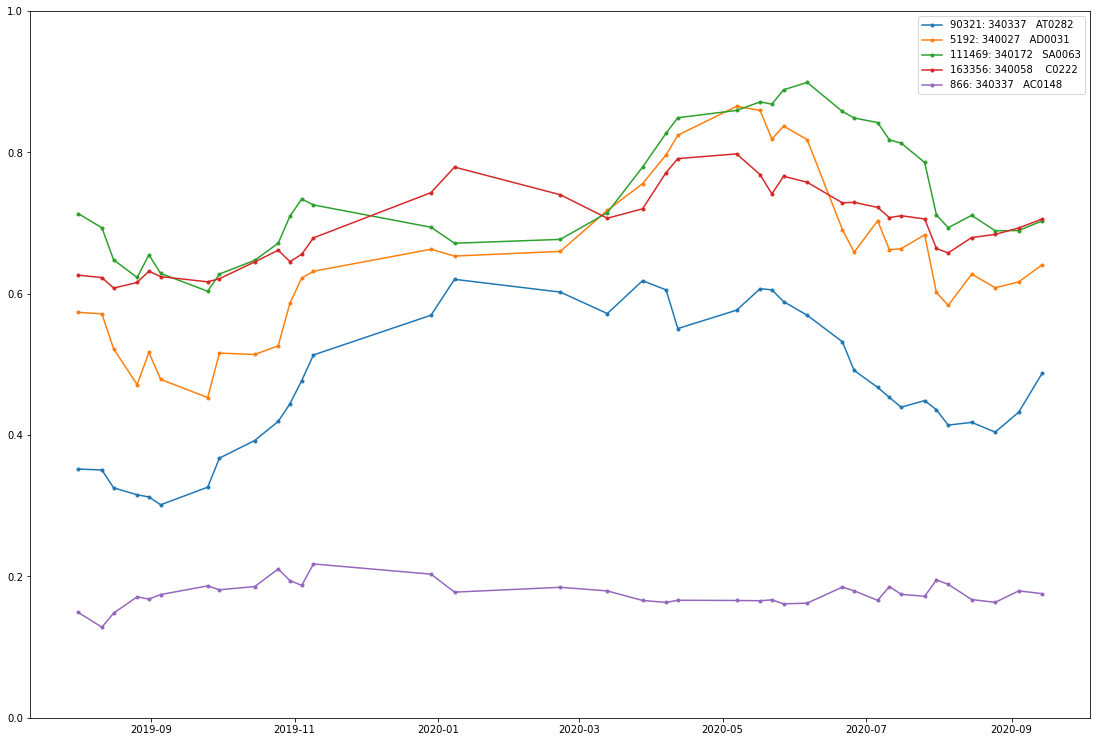

In [71]:
ndvi_plot(choices, ndvi_mean[ndvi_mean.columns[45:]], parcelles_orig, controle_mtp,
          rolling_win=2, reject=3, interpolate=True, size_factor=1.5)

In [6]:
ndvi_diff_mean[ndvi_diff_mean.columns[45:]]

2019-07-22  2019-08-01  2019-08-11  2019-08-16  2019-08-26  \
gid                                                                  
1         0.041502   -0.024566   -0.027779    0.027452   -0.002971   
2         0.014860   -0.094721         NaN         NaN    0.006126   
3        -0.005518         NaN         NaN    0.053855    0.024682   
4         0.042187   -0.010599   -0.023658    0.036958    0.022133   
5         0.014743   -0.020218   -0.105731    0.090461    0.006455   
...            ...         ...         ...         ...         ...   
167663   -0.039460   -0.035505         NaN         NaN   -0.001878   
167664    0.014127   -0.008046         NaN         NaN    0.019565   
167665    0.020512    0.005072         NaN         NaN    0.024109   
167666   -0.016637   -0.000035         NaN         NaN   -0.004517   
167667    0.010020   -0.001716         NaN         NaN    0.001885   

        2019-08-31  2019-09-05  2019-09-25  2019-09-30  2019-10-15  ...  \
gid                                                                 ...   
1        -0.008320    0.026665   -0.027856    0.025017    0.025914  ...   
2        -0.012400   -0.008832         NaN         NaN    0.014755  ...   
3        -0.077821    0.126787   -0.064227   -0.042608    0.121756  ...   
4        -0.047000    0.042708    0.050027         NaN         NaN  ...   
5         0.000300   -0.023715    0.054882   -0.008849    0.020310  ...   
...            ...         ...         ...         ...         ...  ...   
167663   -0.000097   -0.008921    0.047839   -0.017704    0.005173  ...   
167664    0.002776   -0.028316    0.042320    0.020086    0.028244  ...   
167665   -0.007861   -0.014011    0.036486    0.015794    0.045773  ...   
167666    0.011873   -0.010097    0.040829   -0.003335    0.032385  ...   
167667   -0.013739    0.015517    0.016348   -0.001322    0.028554  ...   

        2020-07-06  2020-07-11  2020-07-16  2020-07-26  2020-07-31  \
gid                                                                  
1        -0.037579    0.007732    0.001634   -0.035373    0.053594   
2        -0.117309    0.034598    0.018446   -0.119178    0.052572   
3        -0.015558    0.021342    0.017681   -0.000564    0.046637   
4         0.011427         NaN         NaN    0.008225    0.058916   
5        -0.037363   -0.022325   -0.005891    0.004675   -0.024962   
...            ...         ...         ...         ...         ...   
167663   -0.010997    0.000480   -0.012134    0.001654    0.008866   
167664   -0.034948   -0.013173    0.003009   -0.009370   -0.037440   
167665   -0.031960   -0.008612   -0.000720   -0.001789   -0.038716   
167666   -0.007497   -0.018051    0.002334    0.015452   -0.018138   
167667   -0.045218   -0.032607   -0.010880   -0.008089   -0.000469   

        2020-08-05  2020-08-15  2020-08-25  2020-09-04  2020-09-14  
gid                                                                 
1        -0.024430   -0.009334    0.036691   -0.023489   -0.027893  
2        -0.054854    0.002044    0.064424   -0.070274    0.037112  
3        -0.049145   -0.002300   -0.016385    0.038532    0.002113  
4        -0.053185    0.017077    0.015193    0.021805   -0.053822  
5         0.009666    0.006413   -0.014171    0.027313   -0.000521  
...            ...         ...         ...         ...         ...  
167663   -0.009873   -0.009138    0.005787    0.044645    0.040814  
167664    0.018166   -0.004620    0.019082    0.015468    0.008499  
167665    0.014445   -0.002706    0.017951    0.022009    0.021204  
167666    0.013088   -0.008344    0.006534    0.030504    0.028763  
167667   -0.003769    0.000694    0.014485    0.023000    0.032507  

[153062 rows x 38 columns]

In [7]:
diff30j = time_col_filter(ndvi_diff_mean[ndvi_diff_mean.columns[57:]], "2020-09-14", delta=-30).sum(axis=1).rename('diff_30j')

In [8]:
diff60j = time_col_filter(ndvi_diff_mean[ndvi_diff_mean.columns[57:]], "2020-09-14", delta=-60).sum(axis=1).rename('diff_60j')

In [35]:
filters = (diff60j.index.isin(parcelles[parcelles.area>100].index) & diff60j.index.isin(parcelles_OLD_mtp.index))
selection=diff60j[filters].sort_values(ascending=False).head(1000).index

In [36]:
#parcelles_OLD_mtp.join(diff30j).join(diff60j).to_file('/home/vidlb/Projets/poc_old/traitements/s2/stats/parcelles_OLD_mtp_diff_20200914.shp', index=0)

In [37]:
selection

Int64Index([161109, 146997, 152197, 152204, 147105, 152363, 161045, 148317,
            146340, 148071,
            ...
            152313, 151836, 148423, 146983, 147648, 161131, 147477, 148240,
            151769, 151902],
           dtype='int64', name='gid', length=1000)

In [40]:
parcelles.columns

Index(['id', 'commune', 'prefixe', 'section', 'numero', 'contenance',
       'zone_old', 'bati_pc', 'foret_pc', 'hydro_pc', 'arbo_count', 'arbo_sum',
       'arbo_pct', 'codeident', 'gid', 'geometry', 'classif', 'aire'],
      dtype='object')

In [20]:
p = parcelles_OLD_mtp.join(diff30j).join(diff60j)

In [45]:
p=p[p.index.isin(parcelles_OLD_mtp[parcelles_OLD_mtp.area>1000].index)]

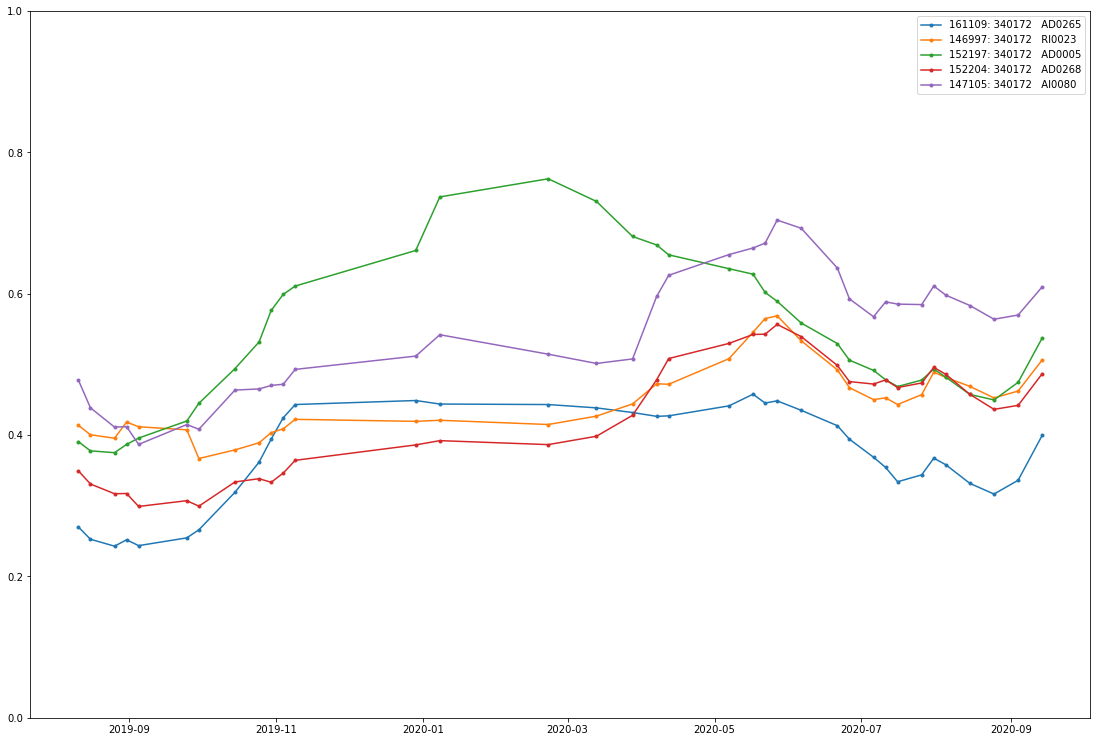

In [77]:
ndvi_plot(selection[:5], ndvi_mean[ndvi_mean.columns[45:]], parcelles_orig, None,
          rolling_win=3, reject=3, interpolate=True, size_factor=1.5)

In [72]:
selection

Int64Index([161109, 146997, 152197, 152204, 147105, 152363, 161045, 148317,
            146340, 148071,
            ...
            152313, 151836, 148423, 146983, 147648, 161131, 147477, 148240,
            151769, 151902],
           dtype='int64', name='gid', length=1000)

In [78]:
ndvi_mean

2018-01-23  2018-01-28  2018-02-07  2018-02-12  2018-02-22  \
1         0.281289    0.273464    0.304102    0.289908    0.300110   
2         0.533802    0.552221    0.626349    0.548354         NaN   
3         0.180639    0.172160    0.207737    0.201035    0.199795   
4         0.279262    0.278364         NaN    0.274231    0.256580   
5         0.468721    0.467058    0.514095    0.459669         NaN   
...            ...         ...         ...         ...         ...   
167663    0.129399    0.138431    0.168378    0.157449         NaN   
167664    0.611967    0.610403    0.653760    0.604417         NaN   
167665    0.687656    0.676709    0.726308    0.676172         NaN   
167666    0.307316    0.339688    0.332859    0.302871    0.288012   
167667    0.366904    0.375398    0.395651    0.373135         NaN   

        2018-02-27  2018-04-18  2018-05-18  2018-06-22  2018-06-27  ...  \
1              NaN    0.273728    0.328958    0.330175    0.348747  ...   
2              NaN    0.636176    0.814029         NaN    0.740538  ...   
3              NaN    0.161313         NaN         NaN    0.144068  ...   
4              NaN    0.280279         NaN         NaN    0.268145  ...   
5              NaN    0.535385    0.609785    0.607295    0.577701  ...   
...            ...         ...         ...         ...         ...  ...   
167663         NaN    0.154647    0.214653    0.333969    0.297296  ...   
167664         NaN    0.569375    0.637400    0.637075    0.655265  ...   
167665         NaN    0.629198    0.694527    0.698108    0.710258  ...   
167666         NaN    0.281372    0.301979    0.303472    0.286850  ...   
167667         NaN    0.354580    0.383621    0.419809    0.408358  ...   

        2020-07-06  2020-07-11  2020-07-16  2020-07-26  2020-07-31  \
1         0.273482    0.281214    0.282848    0.247475    0.301069   
2         0.493263    0.527861    0.546307    0.427129    0.479701   
3         0.132189    0.153531    0.171211    0.170647    0.217285   
4         0.287141         NaN    0.258124    0.266349    0.325265   
5         0.446026    0.423701    0.417810    0.422485    0.397523   
...            ...         ...         ...         ...         ...   
167663    0.305065    0.305545    0.293411    0.295065    0.303931   
167664    0.610465    0.597292    0.600300    0.590930    0.553490   
167665    0.672628    0.664016    0.663296    0.661507    0.622791   
167666    0.275420    0.257369    0.259703    0.275155    0.257017   
167667    0.443080    0.410473    0.399592    0.391503    0.391034   

        2020-08-05  2020-08-15  2020-08-25  2020-09-04  2020-09-14  
1         0.276639    0.267305    0.303996    0.280507    0.252614  
2         0.424847    0.426891    0.491315    0.421041    0.458153  
3         0.168140    0.165841    0.149456    0.187988    0.190101  
4         0.272080    0.289157    0.304350    0.326155    0.272334  
5         0.407189    0.413602    0.399432    0.426744    0.426223  
...            ...         ...         ...         ...         ...  
167663    0.294058    0.284920    0.290708    0.335352    0.376166  
167664    0.571656    0.567036    0.586118    0.601586    0.610085  
167665    0.637235    0.634529    0.652480    0.674489    0.695693  
167666    0.270106    0.261761    0.268295    0.298800    0.327562  
167667    0.387265    0.387959    0.402444    0.425444    0.457952  

[153062 rows x 83 columns]

In [97]:
season_df = pd.merge(time_col_filter(ndvi_mean, '2018-08-01', delta=60), time_col_filter(ndvi_mean, '2019-08-01', delta=60), left_index=True, right_index=True)

In [109]:
def season_data(df: pd.DataFrame, dstart: str, delta=60):
    return time_col_filter(df, dstart.replace('2020','2018'), delta=delta).join(
                   time_col_filter(df, dstart.replace('2020','2019'), delta=delta))

In [99]:
season_df

2018-08-01  2018-08-06  2018-08-11  2018-08-16  2018-08-21  \
1         0.301394    0.305273    0.282641    0.338932    0.315904   
2         0.558974    0.631139    0.537620    0.701364    0.604429   
3         0.227502    0.174674    0.260773    0.167021    0.191184   
4         0.318902    0.276535    0.332444    0.288885    0.354386   
5         0.446240    0.438200    0.445565    0.470546    0.469728   
...            ...         ...         ...         ...         ...   
167663    0.282667    0.306115    0.235466    0.235776    0.246090   
167664    0.587374    0.572059    0.596351    0.618144    0.617938   
167665    0.655440    0.615540    0.665091    0.669803    0.688779   
167666    0.233884    0.249933    0.254044    0.251514    0.257380   
167667    0.387050    0.365919    0.394146    0.385236    0.414021   

        2018-08-26  2018-08-31  2018-09-20  2018-09-25  2019-08-01  \
1         0.363861    0.343118    0.271246    0.331849    0.287359   
2         0.686133    0.585012    0.444240    0.616545    0.484578   
3         0.164872    0.227296    0.306642    0.136120         NaN   
4         0.294021    0.336525    0.381627    0.307587    0.278193   
5         0.467539    0.457654    0.434002    0.452159    0.384465   
...            ...         ...         ...         ...         ...   
167663    0.304004    0.284861    0.210146    0.226781    0.244812   
167664    0.626093    0.624812    0.587415    0.623872    0.538928   
167665    0.675820    0.698531    0.665895    0.685253    0.615247   
167666    0.272925    0.261335    0.268987    0.260546    0.233566   
167667    0.414685    0.438549    0.430304    0.427587    0.353494   

        2019-08-11  2019-08-16  2019-08-26  2019-08-31  2019-09-05  \
1         0.259581    0.287032    0.284061    0.275741    0.302406   
2              NaN    0.467964    0.474090    0.461690    0.452857   
3         0.134270    0.188125    0.212807    0.134986    0.261772   
4         0.254536    0.291494    0.313627    0.266627    0.309334   
5         0.278734    0.369195    0.375650    0.375949    0.352235   
...            ...         ...         ...         ...         ...   
167663         NaN    0.249430    0.247552    0.247455    0.238534   
167664    0.542406    0.498713    0.518278    0.521054    0.492739   
167665    0.610435    0.573857    0.597966    0.590105    0.576093   
167666         NaN    0.231429    0.226912    0.238785    0.228688   
167667    0.348983    0.345015    0.346899    0.333160    0.348677   

        2019-09-25  2019-09-30  
1         0.274549    0.299566  
2              NaN    0.520281  
3         0.197545    0.154937  
4         0.359361         NaN  
5         0.407116    0.398267  
...            ...         ...  
167663    0.286373    0.268669  
167664    0.535059    0.555144  
167665    0.612579    0.628373  
167666    0.269516    0.266181  
167667    0.365025    0.363703  

[153062 rows x 17 columns]

In [122]:
(season_data(ndvi_mean, '2020-09-14', 60).mean(axis=1) - season_data(ndvi_mean, '2020-09-14', 45).mean(axis=1)).describe()

count    153062.000000
mean          0.009652
std           0.017898
min          -0.138810
25%          -0.000549
50%           0.007032
75%           0.016787
max           0.169694
dtype: float64